In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 524 kB 12.9 MB/s 
     |████████████████████████████████| 132 kB 49.2 MB/s 
     |████████████████████████████████| 829 kB 45.8 MB/s 
     |████████████████████████████████| 332 kB 43.7 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
     |████████████████████████████████| 1.1 MB 37.0 MB/s 
     |████████████████████████████████| 160 kB 52.7 MB/s 
     |████████████████████████████████| 271 kB 51.2 MB/s 
     |████████████████████████████████| 192 kB 48.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=a9fd98bfebffdb43eab1cffec116ab2d24bd19eb399e1299663def22a6b42a94
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import tensorflow.keras as keras

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition
from sklearn.feature_extraction import image
from utils import *

In [ ]:
!git clone https://github.com/CIA-Oceanix/DLGD2021.git

Cloning into 'DLGD2021'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 294 (delta 136), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (294/294), 101.86 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [ ]:
!pwd
os.chdir('DLGD2021/lecture-5-inverse-problems')
import solver as solver_4DVarNet



/content


In [ ]:
os.chdir('content')
!pwd

FileNotFoundError: ignored

# L63 Data simulation

In [ ]:
from importlib import reload
import utils
reload(utils) 
from utils import *

In [ ]:
Training_dataset,Val_dataset,Test_dataset = L63PatchDataExtraction(sparsity=0.5,sigma_noise=np.sqrt(2),num_variables=3)


meanTr          = np.mean(Training_dataset['Missing']) / np.mean(Training_dataset['Mask']) 
stdTr           = np.sqrt( np.mean( Training_dataset['Missing']**2 ) / np.mean(Training_dataset['Mask']) )
#visualisation_data(Training_dataset['Truth'],Training_dataset['Obs'],Training_dataset['Init'],125)

In [ ]:
# reshape to 2D tensors to use 
# the 2D implementation of the 4DVarNet
dT = 200
Training_dataset['Truth'] = Training_dataset['Truth'].reshape((-1,dT,3,1)).transpose((0,2,1,3))
Training_dataset['Mask']  = Training_dataset['Mask'].reshape((-1,dT,3,1)).transpose((0,2,1,3))
Training_dataset['Init']  = Training_dataset['Init'].reshape((-1,dT,3,1)).transpose((0,2,1,3))
Training_dataset['Obs']   = Training_dataset['Obs'].reshape((-1,dT,3,1)).transpose((0,2,1,3))

Val_dataset['Truth']      = Val_dataset['Truth'].reshape((-1,dT,3,1)).transpose((0,2,1,3))
Val_dataset['Mask']       = Val_dataset['Mask'].reshape((-1,dT,3,1)).transpose((0,2,1,3))
Val_dataset['Init']       = Val_dataset['Init'].reshape((-1,dT,3,1)).transpose((0,2,1,3))
Val_dataset['Obs']        = Val_dataset['Obs'].reshape((-1,dT,3,1)).transpose((0,2,1,3))

Test_dataset['Truth']     = Test_dataset['Truth'].reshape((-1,dT,3,1)).transpose((0,2,1,3))
Test_dataset['Mask']      = Test_dataset['Mask'].reshape((-1,dT,3,1)).transpose((0,2,1,3))
Test_dataset['Init']      = Test_dataset['Init'].reshape((-1,dT,3,1)).transpose((0,2,1,3))
Test_dataset['Obs']       = Test_dataset['Obs'].reshape((-1,dT,3,1)).transpose((0,2,1,3))

print('..... Training dataset: %dx%dx%dx%d'%(Training_dataset['Truth'].shape[0],Training_dataset['Truth'].shape[1],Training_dataset['Truth'].shape[2],Training_dataset['Truth'].shape[3]))
print('..... Test dataset    : %dx%dx%dx%d'%(Test_dataset['Truth'].shape[0],Test_dataset['Truth'].shape[1],Test_dataset['Truth'].shape[2],Test_dataset['Truth'].shape[3]))

..... Training dataset: 12800x3x200x1
..... Test dataset    : 2560x3x200x1


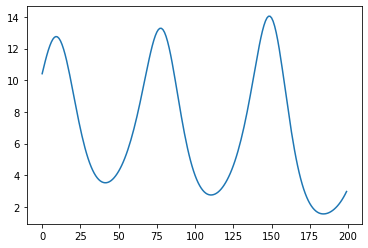

In [ ]:
plt.plot(Test_dataset['Truth'][1,0,:,:])

# Trainable dynamical prior $\Phi$



In [ ]:
flagAEType = 'unet'
DimAE = 10
shapeData  = Training_dataset['Truth'].shape[1:]



dW = 5
class Phi_r(torch.nn.Module):
    def __init__(self):
        super(Phi_r, self).__init__()
        self.pool1  = torch.nn.AvgPool2d((4,1))
        #self.conv1  = ConstrainedConv2d(shapeData[0],2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
        self.conv1  = torch.nn.Conv2d(shapeData[0],2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
        self.conv2  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
        self.conv21 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.conv22 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.conv23 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.conv3  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
        self.conv2Tr = torch.nn.ConvTranspose2d(shapeData[0]*DimAE,shapeData[0],(4,1),stride=(4,1),bias=False)          
        
        self.convHR1  = torch.nn.Conv2d(shapeData[0],2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
        self.convHR2  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
        self.convHR21 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.convHR22 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.convHR23 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
        self.convHR3  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)

    def forward(self, xinp):
        x = self.pool1( xinp )
        x = self.conv1( x )
        x = self.conv2( F.relu(x) )
        x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
        x = self.conv3( x )
        x = self.conv2Tr( x )
          
          
        xHR = self.convHR1( xinp )
        xHR = self.convHR2( F.relu(xHR) )
        xHR = torch.cat((self.convHR21(xHR), self.convHR22(xHR) * self.convHR23(xHR)),dim=1)
        xHR = self.convHR3( xHR )
          
        x   = torch.add(x,1.,xHR)
          
        x = x.view(-1,shapeData[0],shapeData[1],1)
        return x


# Observation model

In [ ]:
# Observation model
class Model_H(torch.nn.Module):
    def __init__(self):
        super(Model_H, self).__init__()
        self.dim_obs = 1
        self.dim_obs_channel = np.array([shapeData[0]])

        self.DimObs = 1
        self.dimObsChannel = np.array([shapeData[0]])

    def forward(self, x, y, mask):
        dyout = (x - y) * mask
        return dyout

# Lightning Class for 4DVarNet

In [ ]:
class HParam:
    def __init__(self):
        self.iter_update     = []
        self.nb_grad_update  = []
        self.lr_update       = []
        self.n_grad          = 1
        self.dim_grad_solver = 10
        self.dropout         = 0.25
        self.w_loss          = []
        self.automatic_optimization = True

        self.alpha_proj    = 0.5
        self.alpha_mse = 10.

        self.k_batch = 1

In [ ]:
EPS_NORM_GRAD = 0. * 1.e-20  
import pytorch_lightning as pl

class LitModel(pl.LightningModule):
    def __init__(self,conf=HParam(),*args, **kwargs):
        super().__init__()
        self.save_hyperparameters()

        # hyperparameters
        self.hparams.iter_update     = [0, 20, 50, 70, 100, 150, 800]  # [0,2,4,6,9,15]
        self.hparams.nb_grad_update  = [5, 5, 10, 10, 15, 15, 20, 20, 20]  # [0,0,1,2,3,3]#[0,2,2,4,5,5]#
        self.hparams.lr_update       = [1e-3, 1e-4, 1e-4, 1e-5, 1e-4, 1e-5, 1e-5, 1e-6, 1e-7]
        
        self.hparams.n_grad          = self.hparams.nb_grad_update[0]
        self.hparams.k_n_grad        = 1
        self.hparams.dim_grad_solver = dimGradSolver
        self.hparams.dropout         = rateDropout
        
        self.hparams.k_batch         = 1
        
        self.hparams.alpha_prior    = 0.5
        self.hparams.alpha_mse = 1.e1        

        self.hparams.w_loss          = torch.nn.Parameter(torch.Tensor(w_loss), requires_grad=False)
        self.hparams.automatic_optimization = False#True#

        # main model
        self.model        = solver_4DVarNet.Solver_Grad_4DVarNN(Phi_r(), 
                                                            Model_H(), 
                                                            solver_4DVarNet.model_GradUpdateLSTM(shapeData, UsePriodicBoundary, self.hparams.dim_grad_solver, self.hparams.dropout), 
                                                            None, None, shapeData, self.hparams.n_grad, EPS_NORM_GRAD)#, self.hparams.eps_norm_grad)
        self.w_loss       = self.hparams.w_loss # duplicate for automatic upload to gpu
        self.x_rec    = None # variable to store output of test method
        self.x_rec_obs = None
        self.curr = 0

        self.automatic_optimization = self.hparams.automatic_optimization
        

    def forward(self):
        return 1

    def configure_optimizers(self):
        optimizer   = optim.Adam([{'params': self.model.model_Grad.parameters(), 'lr': self.hparams.lr_update[0]},
                                      {'params': self.model.model_VarCost.parameters(), 'lr': self.hparams.lr_update[0]},
                                    {'params': self.model.phi_r.parameters(), 'lr': 0.5*self.hparams.lr_update[0]},
                                    ], lr=0.)
        return optimizer
    
    def on_epoch_start(self):
        self.model.n_grad   = self.hparams.n_grad 
        
    def on_train_epoch_start(self):
        self.model.n_grad   = self.hparams.n_grad 

        opt = self.optimizers()
        if (self.current_epoch in self.hparams.iter_update) & (self.current_epoch > 0):
            indx             = self.hparams.iter_update.index(self.current_epoch)
            print('... Update Iterations number/learning rate #%d: NGrad = %d -- lr = %f'%(self.current_epoch,self.hparams.nb_grad_update[indx],self.hparams.lr_update[indx]))
            
            self.hparams.n_grad = self.hparams.nb_grad_update[indx]
            self.model.n_grad   = self.hparams.n_grad 
            
            mm = 0
            lrCurrent = self.hparams.lr_update[indx]
            lr = np.array([lrCurrent,lrCurrent,0.5*lrCurrent,0.])            
            for pg in opt.param_groups:
                pg['lr'] = lr[mm]# * self.hparams.learning_rate
                mm += 1
        
    def training_step(self, train_batch, batch_idx, optimizer_idx=0):
        opt = self.optimizers()
                    
        # compute loss and metrics
        loss, out, metrics = self.compute_loss(train_batch, phase='train')
        
        for kk in range(0,self.hparams.k_n_grad-1):
            loss1, out, metrics = self.compute_loss(train_batch, phase='train',batch_init=out[0],hidden=out[1],cell=out[2],normgrad=out[3])
            loss = loss + loss1
        
        self.log("tr_mse", metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        
        # initial grad value
        if self.hparams.automatic_optimization == False :
            # backward
            self.manual_backward(loss)
        
            if (batch_idx + 1) % self.hparams.k_batch == 0:
                # optimisation step
                opt.step()
                
                # grad initialization to zero
                opt.zero_grad()
         
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        loss, out, metrics = self.compute_loss(val_batch, phase='val')
        for kk in range(0,self.hparams.k_n_grad-1):
            loss1, out, metrics = self.compute_loss(val_batch, phase='val',batch_init=out[0],hidden=out[1],cell=out[2],normgrad=out[3])
            loss = loss1

        #self.log('val_loss', loss)
        self.log('val_loss', metrics['mse'] )
        self.log("val_mse",  metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        loss, out, metrics = self.compute_loss(test_batch, phase='test')
        
        for kk in range(0,self.hparams.k_n_grad-1):
            loss1, out, metrics = self.compute_loss(test_batch, phase='test',batch_init=out[0].detach(),hidden=out[1],cell=out[2],normgrad=out[3])

        #out_ssh,out_ssh_obs = out
        #self.log('test_loss', loss)
        self.log("test_mse", stdTr**2 * metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        #return {'preds': out_ssh.detach().cpu(),'obs_ssh': out_ssh_obs.detach().cpu()}
        return {'preds': out[0].detach().cpu()}

    def training_epoch_end(self, training_step_outputs):
        # do something with all training_step outputs
        print('.. \n')
    
    def test_epoch_end(self, outputs):
        x_test_rec = torch.cat([chunk['preds'] for chunk in outputs]).numpy()
        x_test_rec = x_test_rec      
        self.x_rec = x_test_rec.squeeze()

        return [{'mse':0.,'preds': 0.}]

    def compute_loss(self, batch, phase, batch_init = None , hidden = None , cell = None , normgrad = 0.0):

        inputs_init_,inputs_obs,masks,targets_GT = batch
 
        #inputs_init = inputs_init_
        if batch_init is None :
            inputs_init = inputs_init_
        else:
            inputs_init = batch_init
            
        if phase == 'train' :                
            inputs_init = inputs_init.detach()
            
        with torch.set_grad_enabled(True):
            # with torch.set_grad_enabled(phase == 'train'):
            inputs_init = torch.autograd.Variable(inputs_init, requires_grad=True)

            outputs, hidden_new, cell_new, normgrad_ = self.model(inputs_init, inputs_obs, masks, hidden = hidden , cell = cell , normgrad = normgrad )

            #loss_mse   = solver_4DVarNet.compute_WeightedLoss((outputs - targets_GT), self.w_loss)
            loss_mse = torch.mean((outputs - targets_GT) ** 2)
            loss_prior = torch.mean((self.model.phi_r(outputs) - outputs) ** 2)
            loss_prior_gt = torch.mean((self.model.phi_r(targets_GT) - targets_GT) ** 2)

            loss = self.hparams.alpha_mse * loss_mse
            loss += 0.5 * self.hparams.alpha_prior * (loss_prior + loss_prior_gt)
            
            # metrics
            mse       = loss_mse.detach()
            metrics   = dict([('mse',mse)])
            #print(mse.cpu().detach().numpy())
            if (phase == 'val') or (phase == 'test'):                
                outputs = outputs.detach()
        
        out = [outputs,hidden_new, cell_new, normgrad_]
        
        return loss,out, metrics


# Model training 

In [ ]:
# Pytorch dataloadzers
from pytorch_lightning.callbacks import ModelCheckpoint

UsePriodicBoundary = False # use a periodic boundary for all conv operators in the gradient model (see torch_4DVarNN_dinAE)
w_loss = np.ones(dT) / np.float(dT)
batch_size = 128
idx_val = Training_dataset['Truth'].shape[0]


training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(Training_dataset['Init'][:idx_val:,:,:,:]),torch.Tensor(Training_dataset['Obs'][:idx_val:,:,:,:]),torch.Tensor(Training_dataset['Mask'][:idx_val:,:,:,:]),torch.Tensor(Training_dataset['Truth'][:idx_val:,:,:,:])) # create your datset
val_dataset         = torch.utils.data.TensorDataset(torch.Tensor(Val_dataset['Init'][:idx_val:,:,:,:]),torch.Tensor(Val_dataset['Obs'][:idx_val:,:,:,:]),torch.Tensor(Val_dataset['Mask'][:idx_val:,:,:,:]),torch.Tensor(Val_dataset['Truth'][:idx_val:,:,:,:]))  # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(Test_dataset['Init'][:idx_val:,:,:,:]),torch.Tensor(Test_dataset['Obs'][:idx_val:,:,:,:]),torch.Tensor(Test_dataset['Mask'][:idx_val:,:,:,:]),torch.Tensor(Test_dataset['Truth'][:idx_val:,:,:,:])) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

print(dataset_sizes)

{'train': 12800, 'val': 2560, 'test': 2560}


In [ ]:
# Training from scratch
dimGradSolver = 25
rateDropout = 0.2
mod = LitModel.load_from_checkpoint(checkpoint_path="4DVarNet2.ckpt")
mod.hparams.n_grad          = 5
mod.hparams.k_n_grad        = 1
mod.hparams.iter_update     = [0, 100, 200, 300, 500, 700, 800]  # [0,2,4,6,9,15]
mod.hparams.nb_grad_update  = [5, 5, 5, 5, 15, 15, 20, 20, 20]  # [0,0,1,2,3,3]#[0,2,2,4,5,5]#
mod.hparams.lr_update       = [1e-3, 1e-4, 1e-5, 1e-5, 1e-4, 1e-5, 1e-5, 1e-6, 1e-7]
        
mod.hparams.alpha_prior = 0.1
mod.hparams.alpha_mse = 1.

profiler_kwargs = {'max_epochs': 400 }

trainer = pl.Trainer(gpus=1,  **profiler_kwargs)
trainer.fit(mod, dataloaders['train'], dataloaders['val'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | Solver_Grad_4DVarNN | 40.7 K
----------------------------------------------
40.7 K    Trainable params
200       Non-trainable params
40.9 K    Total params
0.164     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



Validating: 0it [00:00, ?it/s]

.. 



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer.save_checkpoint("4DVarNetL63.ckpt")

In [ ]:

!pwd

/content


# Model testing

In [ ]:
dimGradSolver = 25
rateDropout = 0.2

#print(mod.hparams)
mod.hparams.n_grad = 5
mod.hparams.k_n_grad = 2

print(' Ngrad = %d / %d'%(mod.hparams.n_grad,mod.model.n_grad))
#trainer = pl.Trainer(gpus=1, accelerator = "ddp", **profiler_kwargs)

profiler_kwargs = {'max_epochs': 1}
trainer = pl.Trainer(gpus=1,  **profiler_kwargs)

############################################################
# metrics for validation dataset
trainer.test(mod, test_dataloaders=dataloaders['test'])

X_val = Test_dataset['Truth'].squeeze()
mask_val = Test_dataset['Mask'].squeeze()
var_val  = np.mean( (X_val - np.mean(X_val,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_val) **2 ) 
mse_i   = np.mean( (1.-mask_val.squeeze()) * (mod.x_rec-X_val) **2 ) / np.mean( (1.-mask_val) )
mse_r   = np.mean( mask_val.squeeze() * (mod.x_rec-X_val) **2 ) / np.mean( mask_val )

nmse = mse / var_val
nmse_i = mse_i / var_val
nmse_r = mse_r / var_val

print("..... Assimilation performance (validation data)")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:902: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


 Ngrad = 5 / 5


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mse': 33.036075592041016}
--------------------------------------------------------------------------------
..... Assimilation performance (validation data)
.. MSE ALL.   : 0.128 / 0.002
.. MSE ObsData: 0.119 / 0.002
.. MSE Interp : 0.131 / 0.002


..... Assimilation performance
.. MSE ALL.   : 0.128 / 0.002
.. MSE ObsData: 0.119 / 0.002
.. MSE Interp : 0.131 / 0.002


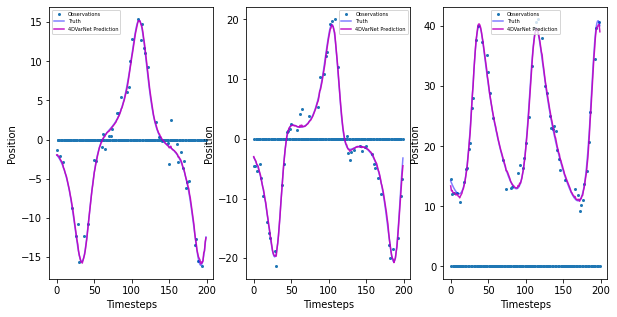

In [ ]:
ii = 110

mod.x_rec = mod.x_rec.squeeze()
x_gt  = Test_dataset['Truth'].squeeze()[ii,:,:]
x_rec = mod.x_rec[ii,:,:]
y_obs = Test_dataset['Obs'].squeeze()[ii,:,:]

## visualization
plt.figure(figsize=(10,5))
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(y_obs[kk,:],'.',label='Observations',ms=4)
  plt.plot(x_gt[kk,:],'b-',alpha=0.5,label='Truth')
  plt.plot(x_rec[kk,:],'m-',alpha=0.9,label='4DVarNet Prediction')
  plt.legend(fontsize=5)
  plt.xlabel('Timesteps')
  plt.ylabel('Position')

# Reconstruction performance
X_test = Test_dataset['Truth'].squeeze()
mask_test = Test_dataset['Mask'].squeeze()
var_test  = np.mean( (X_test - np.mean(X_test,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_test) **2 ) 
mse_i   = np.mean( (1.-mask_test.squeeze()) * (mod.x_rec-X_test) **2 ) / np.mean( (1.-mask_test) )
mse_r   = np.mean( mask_test.squeeze() * (mod.x_rec-X_test) **2 ) / np.mean( mask_test )

nmse = mse / var_test
nmse_i   = mse_i / var_test
nmse_r   = mse_r / var_test

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))

In [ ]:
R_score = 0
mod.x_rec = mod.x_rec.squeeze()
x_gt  = Test_dataset['Truth'].squeeze()
x_rec = mod.x_rec
y_obs = Test_dataset['Obs'].squeeze()

R_score = np.sqrt(((x_rec-x_gt)**2).mean(axis=2)).mean(axis = 0)
print('Variables reconstruction score : {}'.format(R_score))
print('Global reconstruction score : {}'.format(R_score.mean()))

Variables reconstruction score : [0.24320293 0.3292086  0.40818969]
Global reconstruction score : 0.32686707197404835
